In [226]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
import math
from collections import Counter
import matplotlib.pyplot as plt
import statistics

# Read and Combine Data

In [227]:
languages = ['chinese', 'german', 'french', 'thai', 'japanese', 'spanish', 'italian', 'korean', 'russian', 'portuguese']
languageColumns = ['Author', 'Date', 'Rating', 'AuthorKarma']

In [228]:
dfs = []
for language in languages:
    d = pd.read_csv('data/' + language + '.csv')
    d['originalLanguage'] = language
    
    for column in languageColumns:
        d['original' + column] = d[language + column]
        d = d.drop([language + column], axis=1)
    
    dfs.append(d)

data = pd.concat(dfs, axis=0, ignore_index=True)
    

In [229]:
len(data)

219

In [230]:
# add the texts
data['originalText'] = data.apply(lambda x: open('data/' + x['originalLanguage'] + "Originals/" + x['scpId'] + '.txt').read(), axis=1)
data['englishText'] = data.apply(lambda x: open('data/englishFrom' + x['originalLanguage'].capitalize() + "/" + x['scpId'] + '.txt').read(), axis=1)

In [231]:
data.head()

,scpId,href,name,englishRating,englishDate,englishAuthor,englishAuthorKarma,originalLanguage,originalAuthor,originalDate,originalRating,originalAuthorKarma,originalText,englishText
0,SCP-CN-1000,/scp-cn-1000,2300,"+12,+12,+12,+12",29 Mar 2019 00:01,Cynthia7979,very high,chinese,Infas12,30 Oct 2018 15:25,"+574,+574,+574,+574",very high,\n \n\n\n\n\n\n\n评分: +5...,\n \n\n\n\n\n\n\nrating...
1,SCP-CN-994,/scp-cn-994,I See You,+26,18 Mar 2018 07:50,W Asriel,guru,chinese,AndyBlocker,11 Mar 2018 01:28,+858,high,\n \n\n评分: +858+–x\n\n\...,\n \n\nrating: +26+–x\n...
2,SCP-CN-918,/scp-cn-918,NaN,+4,04 May 2018 14:48,Idokoe,high,chinese,qjfoidnh,29 Apr 2018 15:46,+49,very high,\n \n\n评分: +49+–x\n\n\n...,\n \n\nrating: +4+–x\n\...
3,SCP-CN-844,/scp-cn-844,The Seed of Lovesickness,0,20 Jul 2018 07:09,Cynthia7979,very high,chinese,Cynthia7979,02 Jun 2018 14:48,+19,very high,\n \n\n评分: +19+–x\n项目编号...,\n \n\nrating: 0+–x\nIt...
4,SCP-CN-767,/scp-cn-767,Chart Syndrome,+11,10 Aug 2018 14:28,KirkeStein,high,chinese,breaddddd,15 Feb 2018 09:08,+118,very high,\n \n\n评分: +118+–x\n\n\...,\n \n\nrating: +11+–x\n...


# Clean the Data

In [232]:
cleaned = data.drop(['name', 'href'], axis=1)

In [233]:
# fix up ratings
ratingColumns = ['originalRating', 'englishRating']
for column in ratingColumns:
    cleaned[column] = cleaned[column].map(lambda x: float(str(x).split(',')[0]))
    mask = cleaned[column].apply(lambda x: not math.isnan(x))
    cleaned = cleaned[mask]

In [234]:
# tokenize the text
#charLanguages = ['chinese', 'japanese', 'korean', 'thai']
#charLanguages = []
charLanguages = ['chinese', 'japanese', 'thai', 'korean']
cleaned['englishText'] = cleaned['englishText'].apply(lambda x: x.split())
cleaned['originalText'] = cleaned.apply(lambda x: list(x['originalText']) if x['originalLanguage'] in charLanguages else x['originalText'].split(), axis=1)

In [235]:
# remove whitespace
cleaned['originalText'] = cleaned['originalText'].apply(lambda y: list(filter(lambda x: not x.isspace(), y)))
cleaned['englishText'] = cleaned['englishText'].apply(lambda y: list(filter(lambda x: not x.isspace(), y)))

In [236]:
# karma to number
karma = {'none': 0,
         'low': 1,
         'medium': 2,
         'high': 3,
         'very high': 4,
         'guru': 5}
cleaned['authorKarma'] = cleaned['originalAuthorKarma'].apply(lambda x: karma[x])
cleaned['translatorKarma'] = cleaned['englishAuthorKarma'].apply(lambda x: karma[x])

In [237]:
cleaned.head()

,scpId,englishRating,englishDate,englishAuthor,englishAuthorKarma,originalLanguage,originalAuthor,originalDate,originalRating,originalAuthorKarma,originalText,englishText,authorKarma,translatorKarma
0,SCP-CN-1000,12.0,29 Mar 2019 00:01,Cynthia7979,very high,chinese,Infas12,30 Oct 2018 15:25,574.0,very high,"[评, 分, :, +, 5, 7, 4, +, –, x, 评, 分, :, +, 5, ...","[rating:, +12+–x, rating:, +12+–x, Credits, Or...",4,4
1,SCP-CN-994,26.0,18 Mar 2018 07:50,W Asriel,guru,chinese,AndyBlocker,11 Mar 2018 01:28,858.0,high,"[评, 分, :, +, 8, 5, 8, +, –, x, «, S, C, P, -, ...","[rating:, +26+–x]",3,5
2,SCP-CN-918,4.0,04 May 2018 14:48,Idokoe,high,chinese,qjfoidnh,29 Apr 2018 15:46,49.0,very high,"[评, 分, :, +, 4, 9, +, –, x, 静, 止, 状, 态, 的, S, ...","[rating:, +4+–x, SCP-CN-918, in, motionless, s...",4,3
3,SCP-CN-844,0.0,20 Jul 2018 07:09,Cynthia7979,very high,chinese,Cynthia7979,02 Jun 2018 14:48,19.0,very high,"[评, 分, :, +, 1, 9, +, –, x, 项, 目, 编, 号, ：, S, ...","[rating:, 0+–x, Item, #:, SCP-CN-844, Object, ...",4,4
4,SCP-CN-767,11.0,10 Aug 2018 14:28,KirkeStein,high,chinese,breaddddd,15 Feb 2018 09:08,118.0,very high,"[评, 分, :, +, 1, 1, 8, +, –, x, +, 回, 收, 记, 录, ...","[rating:, +11+–x, +, Containment, Record, -, C...",4,3


# Math and Stuff

In [238]:
df = cleaned

In [239]:
df['originalEntropy'] = df.apply(lambda x: entropy(list(map(lambda y: y / len(x['originalText']), Counter(x['originalText']).values()))), axis=1)

In [240]:
df['englishEntropy'] = df.apply(lambda x: entropy(list(map(lambda y: y / len(x['englishText']), Counter(x['englishText']).values()))), axis=1)

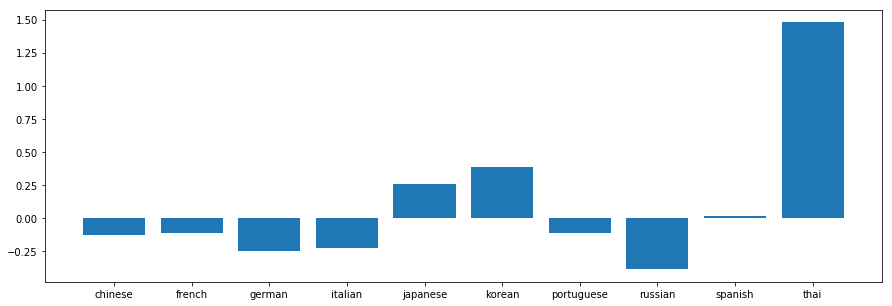

In [241]:
originalEntropy = df.groupby('originalLanguage').apply(lambda x: statistics.mean(x['originalEntropy']))
englishEntropy = df.groupby('originalLanguage').apply(lambda x: statistics.mean(x['englishEntropy']))

y_pos = np.arange(len(languages))
plt.figure(figsize=(15,5))
plt.bar(y_pos, englishEntropy.values - originalEntropy.values)
plt.xticks(y_pos, originalEntropy.index)
plt.show()

### Below are two ways to normalize entropy - use the one without length for now I think

In [ ]:
# z score entropy
averageEnglishEntropy = statistics.mean(df['englishEntropy'])
averageOriginalEntropy = df.groupby('originalLanguage').apply(lambda x: statistics.mean(x['originalEntropy']))
stdevEnglishEntropy = statistics.stdev(df['englishEntropy'])
stdevOriginalEntropy = df.groupby('originalLanguage').apply(lambda x: statistics.stdev(x['originalEntropy']))
df['normalizedEnglishEntropy'] = df['englishEntropy'].apply(lambda x: (x - averageEnglishEntropy) / stdevEnglishEntropy)
df['normalizedOrginalEntropy'] = df.apply(lambda x: (x['originalEntropy'] - averageOriginalEntropy[x['originalLanguage']]) / stdevOriginalEntropy[x['originalLanguage']], axis=1)

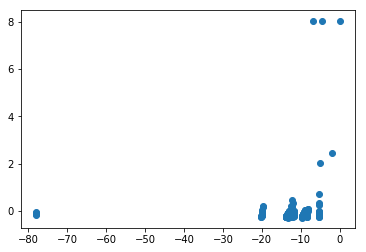

In [243]:
plt.scatter(df['normalizedOrginalEntropy'], df['normalizedEnglishEntropy'])
plt.show()

In [244]:
# z score upvotes
averageEnglishRating = statistics.mean(df['englishRating'])
averageOriginalRating = df.groupby('originalLanguage').apply(lambda x: statistics.mean(x['originalRating']))
stdevEnglishRating = statistics.stdev(df['englishRating'])
stdevOriginalRating = df.groupby('originalLanguage').apply(lambda x: statistics.stdev(x['originalRating']))
df['normalizedEnglishRating'] = df['englishRating'].apply(lambda x: (x - averageEnglishRating) / stdevEnglishRating)
df['normalizedOrginalRating'] = df.apply(lambda x: (x['originalRating'] - averageOriginalRating[x['originalLanguage']]) / stdevOriginalRating[x['originalLanguage']], axis=1)

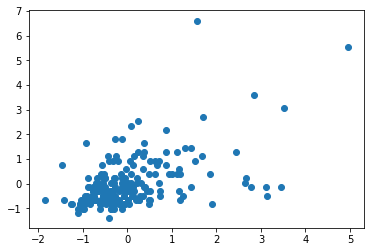

In [245]:
plt.scatter(df['normalizedOrginalRating'], df['normalizedEnglishRating'])
plt.show()

In [246]:
# log rating
zero = 0.1
df['logEnglishRating'] = df['englishRating'].apply(lambda x: np.log(x) if x != 0 else np.log(zero))
df['logOriginalRating'] = df['originalRating'].apply(lambda x: np.log(x) if x != 0 else np.log(zero))

In [247]:
# z score log rating
# z score upvotes
averageLogEnglishRating = statistics.mean(df['logEnglishRating'])
averageLogOriginalRating = df.groupby('originalLanguage').apply(lambda x: statistics.mean(x['logOriginalRating']))
stdevLogEnglishRating = statistics.stdev(df['logEnglishRating'])
stdevLogOriginalRating = df.groupby('originalLanguage').apply(lambda x: statistics.stdev(x['logOriginalRating']))
df['normalizedLogEnglishRating'] = df['logEnglishRating'].apply(lambda x: (x - averageLogEnglishRating) / stdevLogEnglishRating)
df['normalizedLogOrginalRating'] = df.apply(lambda x: (x['logOriginalRating'] - averageLogOriginalRating[x['originalLanguage']]) / stdevLogOriginalRating[x['originalLanguage']], axis=1)

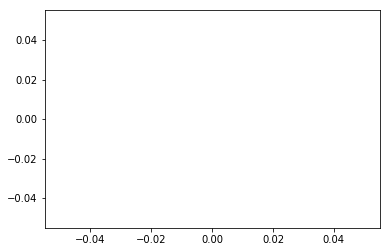

In [248]:
plt.scatter(df['normalizedLogOrginalRating'], df['normalizedLogEnglishRating'])
plt.show()

In [249]:
df.head()

,scpId,englishRating,englishDate,englishAuthor,englishAuthorKarma,originalLanguage,originalAuthor,originalDate,originalRating,originalAuthorKarma,...,originalEntropy,englishEntropy,normalizedEnglishEntropy,normalizedOrginalEntropy,normalizedEnglishRating,normalizedOrginalRating,logEnglishRating,logOriginalRating,normalizedLogEnglishRating,normalizedLogOrginalRating
0,SCP-CN-1000,12.0,29 Mar 2019 00:01,Cynthia7979,very high,chinese,Infas12,30 Oct 2018 15:25,574.0,very high,...,5.785991,6.013945,-0.204590,-5.393089,1.107338,1.677973,2.484907,6.352629,NaN,1.680044
1,SCP-CN-994,26.0,18 Mar 2018 07:50,W Asriel,guru,chinese,AndyBlocker,11 Mar 2018 01:28,858.0,high,...,2.700454,0.693147,8.049713,-4.429984,3.591976,2.849803,3.258097,6.754604,NaN,2.028566
2,SCP-CN-918,4.0,04 May 2018 14:48,Idokoe,high,chinese,qjfoidnh,29 Apr 2018 15:46,49.0,very high,...,4.797172,4.774991,0.255832,-5.242792,-0.312454,-0.488263,1.386294,3.891820,NaN,-0.453535
3,SCP-CN-844,0.0,20 Jul 2018 07:09,Cynthia7979,very high,chinese,Cynthia7979,02 Jun 2018 14:48,19.0,very high,...,5.343681,5.801107,-0.169902,-5.388117,-1.022351,-0.612048,-2.302585,2.944439,NaN,-1.274936
4,SCP-CN-767,11.0,10 Aug 2018 14:28,KirkeStein,high,chinese,breaddddd,15 Feb 2018 09:08,118.0,very high,...,3.184537,3.075841,2.015805,-5.050958,0.929864,-0.203557,2.397895,4.770685,NaN,0.308461


In [250]:
stdevLogEnglishRating

nan

In [251]:
statistics.stdev(df['logEnglishRating'])

nan

In [252]:
# giving up on that...

In [253]:
df['deltaNormalizedEntropy'] = df['normalizedEnglishEntropy'] - df['normalizedOrginalEntropy']
df['deltaNormalizedRating'] = df['normalizedEnglishRating'] - df['normalizedOrginalRating']
df['deltaEntropy'] = df['englishEntropy'] - df['originalEntropy']
df['deltaRating'] = df['englishRating'] - df['originalRating']

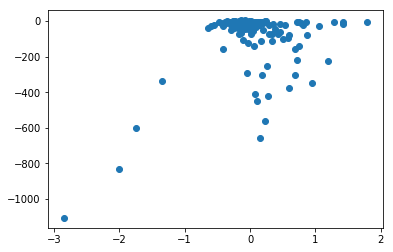

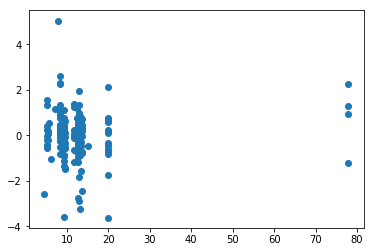

In [254]:
def ratingVsEntropy(stuff):
    plt.scatter(stuff['deltaEntropy'], stuff['deltaRating'])
    plt.show()
def ratingVsEntropy_Normalized(stuff):
    plt.scatter(stuff['deltaNormalizedEntropy'], stuff['deltaNormalizedRating'])
    plt.show()
ratingVsEntropy(df)
ratingVsEntropy_Normalized(df)

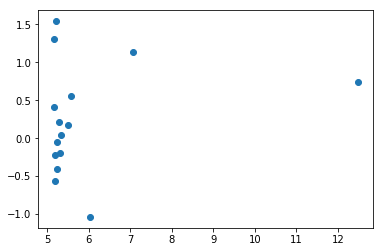

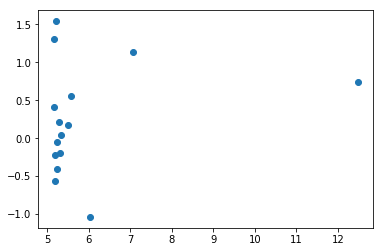

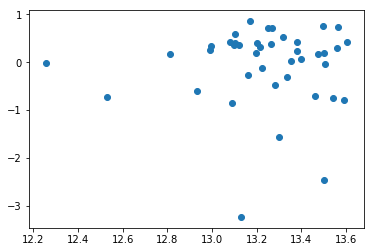

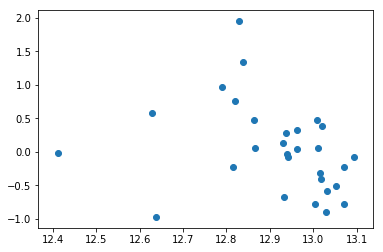

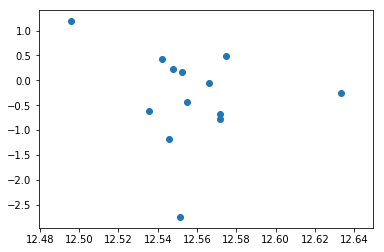

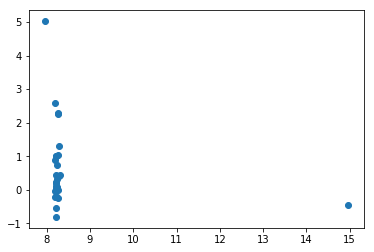

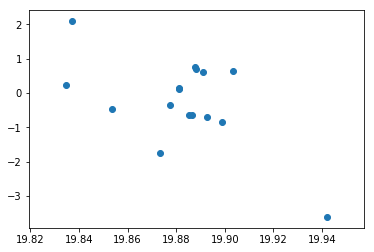

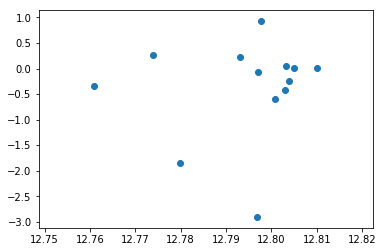

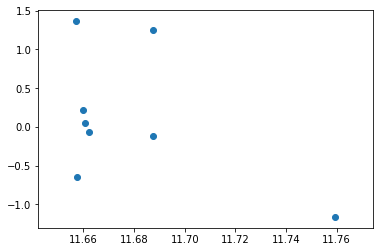

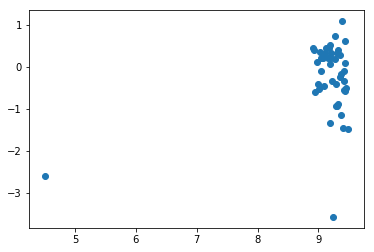

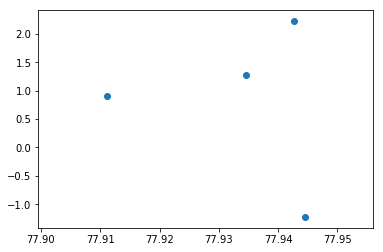

""


In [255]:
df.groupby('originalLanguage').apply(ratingVsEntropy_Normalized)

(array([ 7.,  0.,  5.,  0., 21.,  0., 23.,  0., 93., 64.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

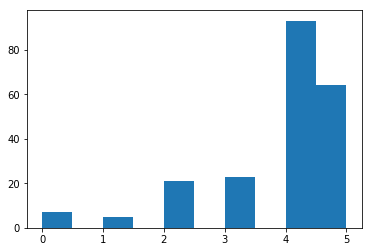

In [256]:
plt.hist(df['translatorKarma'])

(array([ 6.,  0.,  5.,  0., 13.,  0., 33.,  0., 93., 63.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

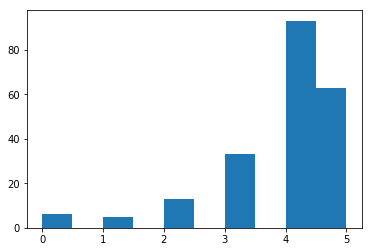

In [257]:
plt.hist(df['authorKarma'])

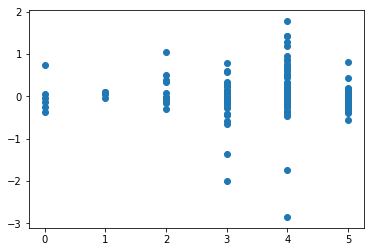

In [258]:
plt.scatter(df['authorKarma'], df['deltaEntropy'])
plt.show()

In [259]:
#df.groupby('englishAuthor').apply(lambda x: statistics.mean(x['englishRating']))

(array([ 1.,  1.,  1.,  1.,  3., 93., 88., 17.,  5.,  3.]),
 array([-2.85520375, -2.39124473, -1.9272857 , -1.46332668, -0.99936766,
        -0.53540863, -0.07144961,  0.39250941,  0.85646844,  1.32042746,
         1.78438649]),
 <a list of 10 Patch objects>)

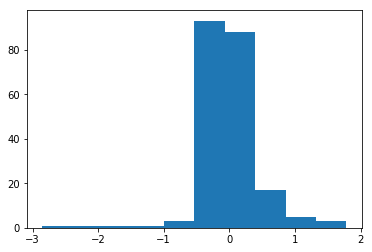

In [260]:
plt.hist(df['deltaEntropy'])

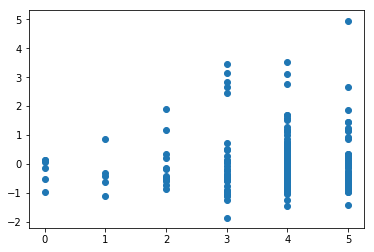

In [261]:
plt.scatter(df['authorKarma'], df['normalizedOrginalRating'])
plt.show()

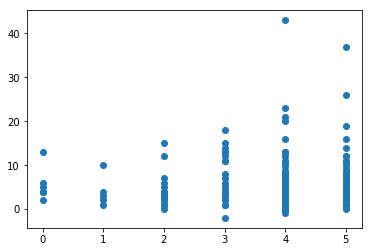

In [262]:
plt.scatter(df['translatorKarma'], df['englishRating'])
plt.show()

In [263]:
# plt.imshow(zip(df['translatorKarma'], df['authorKarma']))
# plt.show()

In [264]:
eliminate = ['thai']
eliminated = df[df['originalLanguage'].apply(lambda x: x not in eliminate)]


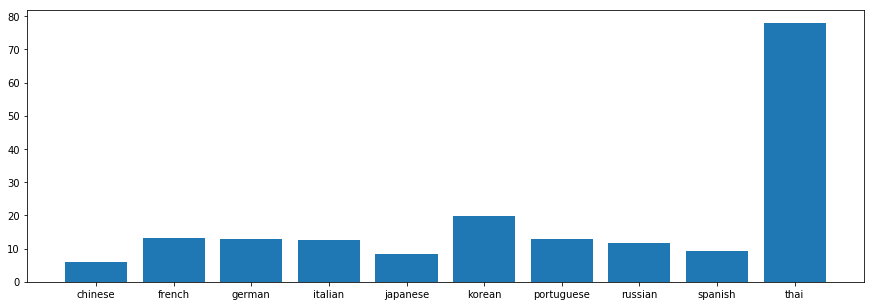

In [265]:
y_pos = np.arange(len(languages))
plt.figure(figsize=(15,5))
normalizedEntropy = df.groupby('originalLanguage').apply(lambda x: statistics.mean(x['deltaNormalizedEntropy']))
plt.bar(y_pos, normalizedEntropy.values)
plt.xticks(y_pos, normalizedEntropy.index)
plt.show()

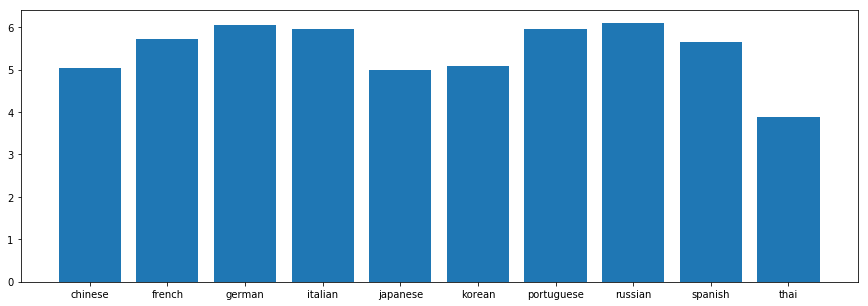

In [266]:
y_pos = np.arange(len(languages))
plt.figure(figsize=(15,5))
normalizedEntropy = df.groupby('originalLanguage').apply(lambda x: statistics.mean(x['originalEntropy']))
plt.bar(y_pos, normalizedEntropy.values)
plt.xticks(y_pos, normalizedEntropy.index)
plt.show()

In [267]:
averageEnglishEntropy

0.012448605525071398

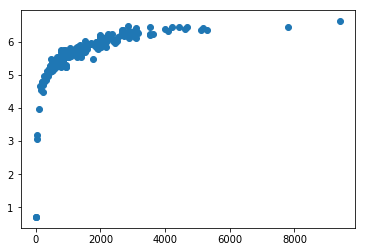

In [268]:
plt.scatter(df['englishText'].apply(len), df['englishEntropy'])